# GP-FS vs GP-AR

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

In [45]:
#GP_FS
#gen data

def GP_FS(prior_X, prior_y, gpr):
    X = np.array(prior_X)
    y = np.array(prior_y)
    reward_vec = []
    rng = np.random.default_rng()
    
    for i in tqdm(range(T), leave = False):
        #v = B + sqrt(2*(gamma+1+ln(2/delta)))
        v = 1
        D_t = np.random.uniform(x_min, x_max, 100)
        #TODO: |D_t| = (BLrdt^2)^d = BLrt^2

        ct = time.time()
        gpr.fit(X.reshape(-1, 1), y)
        #y_mean, y_cov = gp.predict(D_t.reshape(-1, 1), return_cov=True)
        print("fit took " + str(time.time()-ct) + "for i=" + str(i))
        ct = time.time()
        yy = gp.sample_y(D_t.reshape(-1, 1))
        print("sample took " + str(time.time()-ct) + "for i=" + str(i))
        
        newIdx = np.argmax(yy)
        newX = D_t[newIdx]
        newY = samplef(newX)
        X = np.append(X, newX)
        y = np.append(y, newY)
    
        reward_vec.append(newY)
    return reward_vec

#Xcont = np.linspace(x_min,x_max,200)
#Xtest = np.reshape(Xcont,(len(Xcont),1))
#gpr.fit(np.reshape(X, (len(X), 1)), y)
#pred_mean, pred_cov = gpr.predict(Xtest, return_cov=True)
#plt.plot(X, y,'og',markersize=10,label='training data')
#plt.plot(Xcont, pred_mean, label='predictive mean')
#plt.plot(Xcont, truef(Xcont), ':r', label='ground truth')

In [46]:
#GP_AR
def GP_AR(data_X, data_Y):
    X = np.array([])
    y = np.array([])
    
    reward_vec = []
    rng = np.random.default_rng()
    
    for i in tqdm(range(T), leave = False):
        realPlay = False
        while(not realPlay):
            #v = B + sqrt(2*(gamma+1+ln(2/delta)))
            v = 1
            size_d = (i+1)*2
            w = (x_max - x_min)/(size_d)
            #D_t = np.linspace(x_min+w/2, x_max-w/2, num=(size_d))
            D_t = np.random.uniform(x_min, x_max, 100)
            #TODO: |D_t| = (BLrdt^2)^d = BLrt^2
            gpr.fit(np.reshape(X, (len(X), 1)), y)
            #ct = time.time()
            pred_mean, pred_cov = gpr.predict(np.reshape(D_t,(len(D_t),1)), return_cov=True)
            #print("predict took " + str(time.time()-ct) + "for i=" + str(i))
            #ct = time.time()
            yy = rng.multivariate_normal(pred_mean, v*v*pred_cov, method="eigh")
            #print("sample took " + str(time.time()-ct) + "for i=" + str(i))
            
            newIdx = np.argmax(yy)
            newX = D_t[newIdx]
            X = np.append(X, newX)
            
            if(len(data_X) > 0):
                data_dist = (np.abs(data_X - newX))
                if(np.min(data_dist) < w/2):
                    idx = np.argmin(data_dist)
                    newY = data_Y[idx]
                    data_X = np.delete(data_X, idx)
                    data_Y = np.delete(data_Y, idx)
                else:
                    newY = samplef(newX)
                    realPlay = True
            else:
                newY = samplef(newX)
                realPlay = True
                
            y = np.append(y, newY)
        reward_vec.append(newY)
    return reward_vec

#plt.plot(range(T), regret_vec)
#plot_result(pred_mean, pred_cov, Xcont, 0)

In [50]:
#hyperparams and such
def truef(x):
  m = 1.5
  return 0.25 * np.exp(-(x-m)*(x-m)/0.2)

def samplef(x):
    VAR = 1
    return truef(x) + np.random.normal(0,VAR)

x_min = -3
x_max = 3

beta = 1
theta = [2.0, 0.2, 0.0, 0.0]

kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0)
T = 200

In [51]:
plotNum = 3
names = ["FS", "AR", "TS"]
colors = ["red", "green", "blue"]

N = 100 #num of data points)
samples = 50
reg_vecs = [np.zeros((samples, T)) for _ in range(plotNum)]

for i in tqdm(range(samples)):
    #data_X = np.random.uniform(x_min, x_max, N)
    data_X = np.linspace(x_min, x_max, num = N)
    data_Y = np.array([samplef(p) for p in data_X])

    fs_reg = GP_FS(data_X, data_Y, gp)
    #ar_reg = GP_AR(data_X, data_Y)
    ts_reg = GP_FS([],[])

    reg_vecs[0][i] = np.cumsum(fs_reg)
    reg_vecs[1][i] = np.cumsum(ar_reg)
    reg_vecs[2][i] = np.cumsum(ts_reg)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

fit took 0.08430194854736328for i=0
sample took 0.022127151489257812for i=0
fit took 0.005350828170776367for i=1
sample took 0.0028829574584960938for i=1
fit took 0.00391387939453125for i=2
sample took 0.004308938980102539for i=2
fit took 0.004034996032714844for i=3
sample took 0.0022881031036376953for i=3
fit took 0.0036041736602783203for i=4
sample took 0.0038352012634277344for i=4
fit took 0.004715919494628906for i=5
sample took 0.0023832321166992188for i=5
fit took 0.003638029098510742for i=6
sample took 0.0029468536376953125for i=6
fit took 0.004659891128540039for i=7
sample took 0.003873109817504883for i=7
fit took 0.0037469863891601562for i=8
sample took 0.0031099319458007812for i=8
fit took 0.004561901092529297for i=9
sample took 0.002997875213623047for i=9
fit took 0.0045168399810791016for i=10
sample took 0.003240823745727539for i=10
fit took 0.004040956497192383for i=11
sample took 0.003361940383911133for i=11
fit took 0.0041768550872802734for i=12
sample took 0.003051042556

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warn

LinAlgError: ("The kernel, RBF(length_scale=0.1), is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '137-th leading minor of the array is not positive definite')

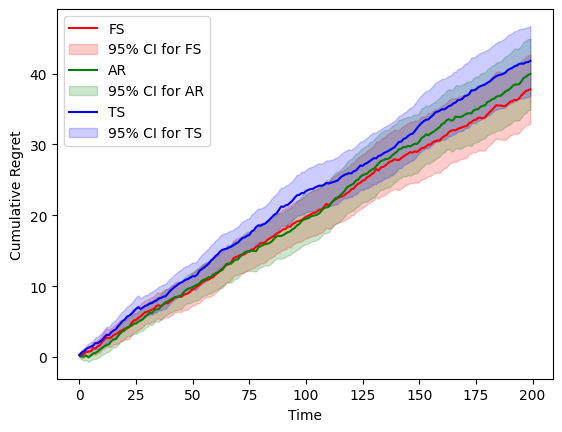

In [162]:
c = range(T)

avg_regrets = []
regret_CIs = []
for i in range(plotNum):
    avg = np.mean(reg_vecs[i], axis=0)
    avg_regrets.append(avg)
    regret_CIs.append([avg-2*np.std(reg_vecs[i],axis=0)/np.sqrt(samples),
                       avg+2*np.std(reg_vecs[i],axis=0)/np.sqrt(samples)])

    plt.plot(c, avg_regrets[i], color = colors[i], label = names[i])
    plt.fill_between(c, regret_CIs[i][0][:],regret_CIs[i][1][:],alpha=0.2,label='95% CI for ' + names[i],color=colors[i])

plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()

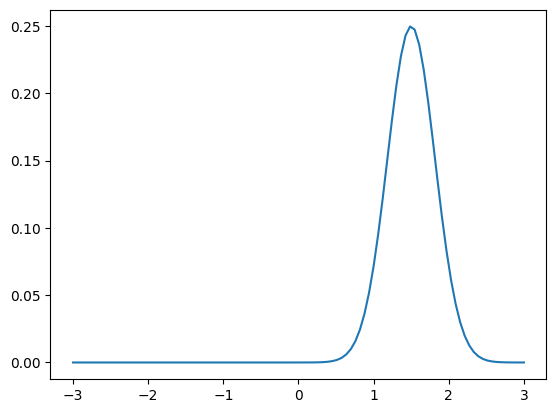

In [157]:
D_t = np.linspace(x_min, x_max, 100)
plt.plot(D_t, np.vectorize(truef)(D_t))